#Predicting Undervalued Major League Baseball Players, and Future Stars Machine Learning Model

> ML model used - Linear Regression

> Prediction/Dependant variable - WAR (Wins Above Replacement) More on WAR: https://www.baseball-reference.com/glossary/wins-above-replacement/

> A detailed explanation of every baseball statistic used in this project can also be found here: https://www.baseball-reference.com/glossary/


>Our goal in this assignment is to predict a future players value while simultaneously finding undervalued



*Players below, Mickey Mantle, Juan Soto, & Jackson Merrill, two proven players from different era's, who's early career statistics showed predictable future success and a 3rd who based on our ML model has a high liklihood of becoming a star.*

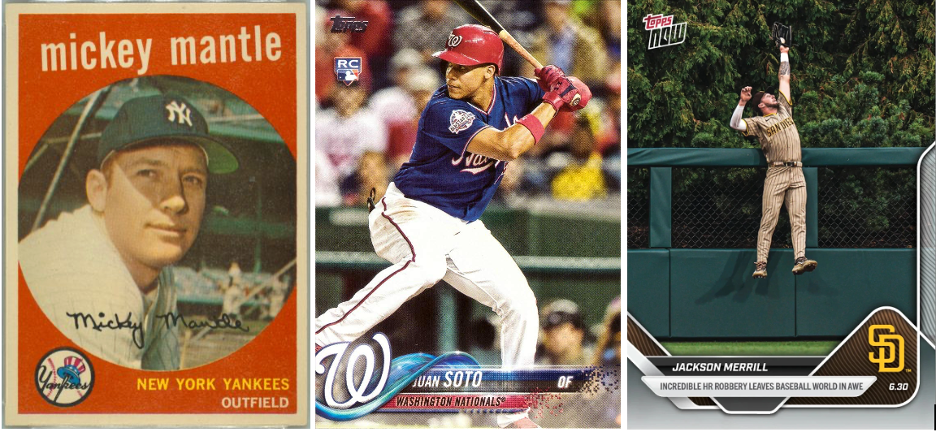

These libraries provide the necessary tools to process the dataset, visualize player trends, and execute the calculations required for the linear regression model. pandas & numpy are standard data science packages for data manipulation, matplotlib & seaborn for data visualization, and sklearn for predictive machine learning.

In [14]:
# 1. Import Necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Set visual theme
sns.set_theme(style="whitegrid", palette="muted")

Before modeling, it is essential to understand the "shape" of the data—identifying column names (like AVG, OBP, war) and check for missing values that might disrupt the math. Here we will load in our historical dataset, explicity select our 16 "people" files and create a master list and dataframe of them, to prepare our next merge step.

In [22]:
#2. Read in our data

# Load your performance stats
df_stats = pd.read_csv('the_baseball_scholar_batting_stats_1901_present_csv.csv')

# Define the list of all people files (0-9 and a-f)
people_file_list = [
    'people-0.csv', 'people-1.csv', 'people-2.csv', 'people-3.csv',
    'people-4.csv', 'people-5.csv', 'people-6.csv', 'people-7.csv',
    'people-8.csv', 'people-9.csv', 'people-a.csv', 'people-b.csv',
    'people-c.csv', 'people-d.csv', 'people-e.csv', 'people-f.csv'
]

# Loop through and combine all people files into one master dataframe
df_people_list = []
for file in people_file_list:
    temp_df = pd.read_csv(file, dtype={9: str, 10: str})
    df_people_list.append(temp_df)

df_people = pd.concat(df_people_list, ignore_index=True)

Next, we'll bridge the two tables together using the unique Baseball-Reference IDs. This creates a master dataset where every hitting season is linked to the player's biological age.

*Note, usually I would work off of a single dataset, but I would also like to display some foundational knowledge on completing joins in pandas as this is also meant for employers*


We will then filter the data to only include players with more than 50 Plate Appearances (pa > 50). In baseball, if a player goes 3-3 in a single game, their batting average will be 1.000, but that is a small sample of only 3 at bats. Counting players who have at least 50 at bats allows us to maintain statistical significance for our model.

*Note, This is also why players do not qualify for certain awards unless they have at least 3.1 plate appearances (PA) per scheduled team game, which usually totals 502 PAs in a full 162-game season*

In [16]:
#3. Joining, Filtering, & Career WAR

# 1. Calculate Total Career WAR for every player for context
career_war = df_stats.groupby('bbref_player_id')['war'].sum().reset_index()
career_war.columns = ['bbref_player_id', 'Total_Career_WAR']

# 2. Join performance data with names and birth years from your combined df_people
# We match 'bbref_player_id' to 'key_bbref'
df = pd.merge(df_stats, df_people[['key_bbref', 'birth_year', 'name_first', 'name_last']],
              left_on='bbref_player_id', right_on='key_bbref', how='inner')

# 3. Add the Career WAR column to every row
df = pd.merge(df, career_war, on='bbref_player_id', how='left')

# 4. Filter for statistical significance (minimum 50 Plate Appearances)
df = df[df['pa'] > 50].copy()

The code in our fourth step of feature engineering creates the age feature and calculates advanced hitting/offensive ratios like OBP and Slugging %. Here we are doing predictive engineering. The model can now "see" that a high OBP from a 21-year-old is strong indicator of future potential, whereas the same OBP from a 39-year-old represents veteran stability.

Raw stats (like just "Hits") don't tell the whole story. This step transforms raw data into Engineered Features that represent specific skills. For example, OBP measures a player's ability to get on base, and avoid making an out. this includes walks, hits, if the player was hit by a pitch, and more. Creating these features allows the model to test which specific skill is the most valuable.




In [17]:
#4. Calculate standard offensive skill features, & age of player

# Calculate Player Age for each specific season
df['age'] = df['season'] - df['birth_year']

# Calculate standard offensive skill features (AVG, OBP, SLG, and OPS)
df['AVG'] = df['h'] / df['ab']
df['OBP'] = (df['h'] + df['bb'] + df['hbp']) / (df['ab'] + df['bb'] + df['hbp'] + df['sf'])
df['SLG'] = (df['1b'] + 2*df['2b'] + 3*df['3b'] + 4*df['hr']) / df['ab']
df['OPS'] = df['OBP'] + df['SLG']

# Clean up rows with missing values to prevent model errors
df = df.dropna(subset=['age', 'OBP', 'SLG', 'OPS', 'war'])

Here we're doing one of my favorite parts of any ML project, designing visualizations in what is known in the world of Data Science as "Exploratory Data Analysis" (EDA).

This is a "pre-test" for my theory. In predictive modeling, you want to see which features have the strongest connection to your target or dependant variable (WAR). If a feature has a low correlation, you might choose to remove it. This step ensures you are feeding the model the most impactful information.

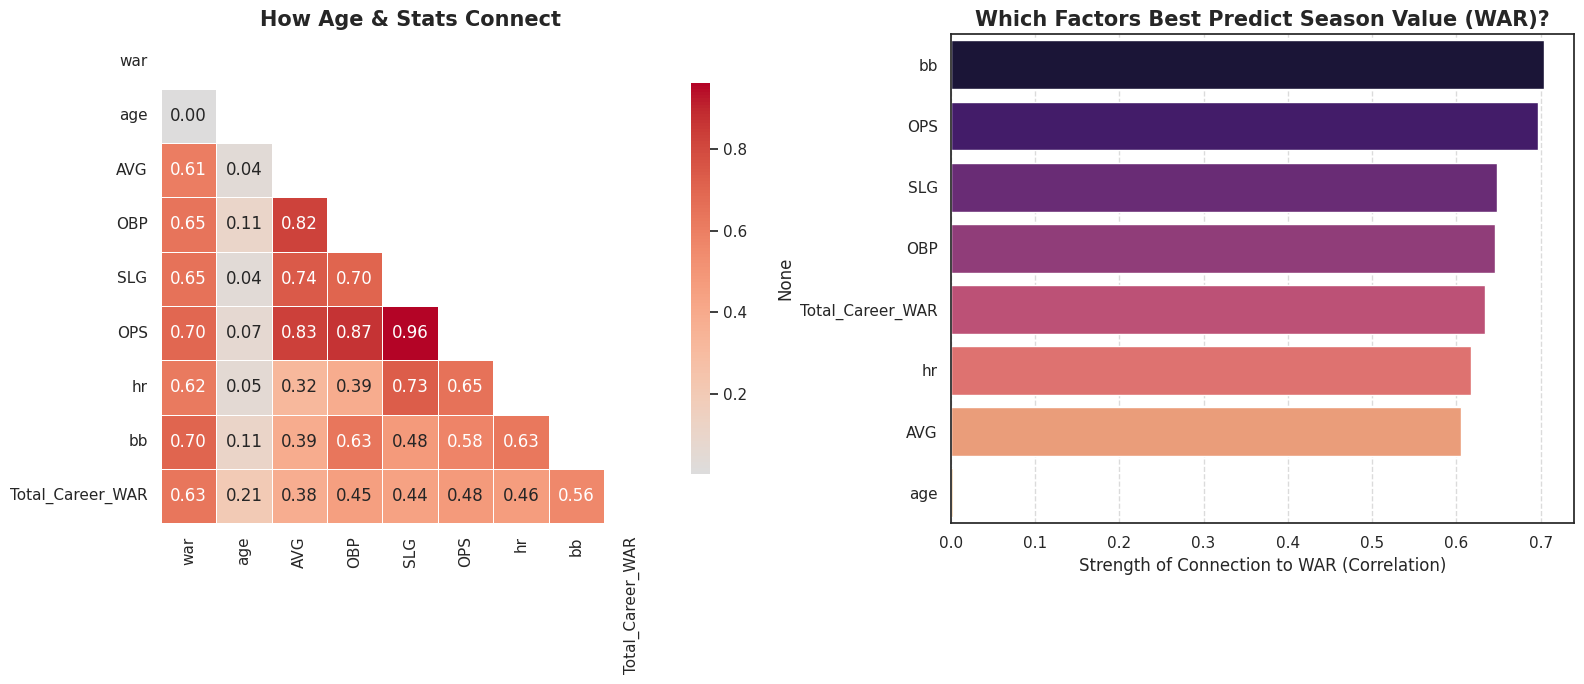

In [24]:
# 5. Data Visualization (Predictive Insights)

# We create a 1x2 dashboard to see correlations
sns.set_theme(style="white", palette="magma")
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_columns = ['war', 'age', 'AVG', 'OBP', 'SLG', 'OPS', 'hr', 'bb', 'Total_Career_WAR']
corr_matrix = df[plot_columns].corr()

# Plot A: Professional Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hides the redundant top half
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt=".2f", linewidths=.5, ax=axes[0], cbar_kws={"shrink": .8})
axes[0].set_title('How Age & Stats Connect', fontsize=15, fontweight='bold')

# Plot B: The "Predictive Impact Ranking" (Correlation with WAR)
# This shows exactly how much 'Age' and other stats drive single-season value
war_impact = corr_matrix['war'].sort_values(ascending=False).drop('war')

sns.barplot(
    x=war_impact.values,
    y=war_impact.index,
    hue=war_impact.index,
    palette="magma",
    ax=axes[1],
    legend=False
)

axes[1].set_title('Which Factors Best Predict Season Value (WAR)?', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Strength of Connection to WAR (Correlation)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('enhanced_predictive_dashboard.png')

Overview of step 6

Here we split the data into two piles: 80% for Training and 20% for Testing, which is standard procedure for most train/test splits. We'll then scale the training data to ensure all stats (like .300 AVG vs 40 HRs) are on a level playing field.

To predict the future, our model must be treated like a student. we give it the training set to "study/learn." Then, the testing set acts as a "final exam" with questions the model has never seen. If the model does well on the test, we can trust it to predict the value of current real-world players.

In [19]:
# Select the predictive features (The clues the model will use)
X = df[['age', 'OBP', 'SLG', 'OPS', 'hr', 'bb']]
y = df['war']

# SPLIT: 80% to train, 20% to act as "the future" (unseen test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SCALE: Standardize stats to a common range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TRAIN: The model learns the rules of player value
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

Finally, the model predicts the WAR for the "Test" group, calculates the R-Squared (Accuracy), MAE (Mean Absolute Error) and also ranks the "Importance Weights" of each stat.

This provides the "Grade" for our model. The R-Squared tells us how much of a player's value the model actually understands. By looking at the importance weights, we can see which specific skills (like OBP) are the most reliable indicators of a future star's value, allowing you to find "undervalued" talent effectively.

In [20]:
#7. Historical Results with Career Context ---

# 1. Generate predictions for the hidden test set
test_preds = model.predict(X_test_scaled)
test_results = X_test.copy()

# 2. Pull names and Career WAR info back using the row index
test_results['Name'] = df.loc[X_test.index, 'name_first'] + " " + df.loc[X_test.index, 'name_last']
test_results['Predicted_WAR'] = test_preds
test_results['Actual_WAR'] = y_test
test_results['Career_WAR'] = df.loc[X_test.index, 'Total_Career_WAR']

print(f"Model Prediction Accuracy (R2): {r2_score(y_test, test_preds):.4f}")

# 3. Filter for young stars (Ages 18-23)
young_stars_historical = test_results[test_results['age'] <= 23].copy()

# 4. Sort by Predicted_WAR descending so the best season is on top
young_stars_historical = young_stars_historical.sort_values(by='Predicted_WAR', ascending=False)

# 5. Remove duplicate names to show distinct players
# keep='first' ensures we keep the row with the highest Predicted_WAR for that name
distinct_historical_stars = young_stars_historical.drop_duplicates(subset=['Name'], keep='first')

print("\nTop 10 Predicted Historical Young Stars (Ages 18-23) - Distinct Players:")
print(distinct_historical_stars[['Name', 'age', 'Predicted_WAR', 'Actual_WAR', 'Career_WAR']].head(10))

Model Prediction Accuracy (R2): 0.6388

Top 10 Predicted Historical Young Stars (Ages 18-23) - Distinct Players:
                  Name   age  Predicted_WAR  Actual_WAR  Career_WAR
739          Juan Soto  23.0       7.664045        7.33       42.60
567       Frank Thomas  23.0       7.522571        6.98       73.82
1348      Ted Williams  22.0       6.069429        6.60      121.80
706          Al Kaline  21.0       5.332169        8.25       92.79
972   Rickey Henderson  22.0       5.205165        8.82      111.18
1298      Arky Vaughan  22.0       5.192945        7.29       77.94
3810     Manny Ramirez  23.0       5.058065        2.95       69.33
2002     Jason Heyward  21.0       4.711425        6.42       41.53
3568    Cody Bellinger  22.0       4.692978        3.97       30.44
1982    Miguel Cabrera  22.0       4.671849        5.18       67.23


This data is very insightful, our model looks at thousands of players at or around their year 23 season, to predict future success. Here in step 7, It shows past players seasons at that age and uses their best season to train our ML model. Our output displays their predicted WAR, Actual WAR and their total career war to apply an additional perspective on value.

Now, we need to see our future stars and apply our model to just the most current season.

In [21]:
#8. Our Final Step: Future Scouting (The 2025 Stars)

#prevents indenting and wrapping in output and sets display width for dataframes
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# 1. Identify and Filter for the Current Season
latest_year = df['season'].max()
current_players = df[df['season'] == latest_year].copy()

# 2. Prepare Features and Run Prediction
X_active = current_players[['age', 'OBP', 'SLG', 'OPS', 'hr', 'bb']]
X_active_scaled = scaler.transform(X_active)
current_players['Predicted_Value'] = model.predict(X_active_scaled)

# 3. Filter for Young Stars (Age 23 or younger)
future_stars = current_players[current_players['age'] <= 23].copy()

# 4. Sort by Predicted_Value descending
future_stars = future_stars.sort_values(by='Predicted_Value', ascending=False)

# 5. Ensure players show up only once (handles mid-season trades)
distinct_future_stars = future_stars.drop_duplicates(subset=['name_first', 'name_last'], keep='first')

print(f"\n--- TOP 30 ACTIVE YOUNG STARS (Age 23 or Under - {latest_year}) ---")
cols_to_show = ['name_first', 'name_last', 'age', 'Predicted_Value', 'war', 'Total_Career_WAR']
print(distinct_future_stars[cols_to_show].head(30))


--- TOP 30 ACTIVE YOUNG STARS (Age 23 or Under - 2025) ---
      name_first       name_last   age  Predicted_Value   war  Total_Career_WAR
985         Nick           Kurtz  22.0         5.010725  5.37              5.37
5163       James            Wood  23.0         4.563170  3.68              4.78
3928      Junior        Caminero  22.0         3.531502  4.47              5.23
8906        Elly      De La Cruz  23.0         3.447237  3.57              9.50
4293       Roman         Anthony  21.0         2.813222  3.14              3.14
15223      Nolan        Schanuel  23.0         2.770518  1.33              2.69
21059    Jackson        Holliday  22.0         2.479026  1.03              1.08
5441      Colson      Montgomery  23.0         2.316593  3.31              3.31
4589        Pete  Crow-Armstrong  23.0         2.271110  5.97              8.15
8887        Kyle            Teel  23.0         2.211136  1.94              1.94
11592    Jackson         Chourio  21.0         2.171825  2.2

#Summary, Conclusion and Future Changes





After combining over 100 years of historical baseball data with modern machine learning, this project identifies players from previous generations who fit the "Digital Scout" profile

 *("Digital Scout" profile refers to a modern, data-driven persona of a baseball player. Instead of a traditional scout watching a game and taking notes on a player's "swing mechanics" or "hustle," the Digital Scout uses machine learning to build a profile based entirely on high-level data and hidden patterns.)*

. It successfully moves beyond simple box scores to understand the deeper relationship between a player's age, their ability to get on base, and their total contribution to a team's success.

Next Steps & Real-World Application
I am planning a second phase for this project, which will include player salaries to determine if individuals are undervalued or overvalued in the market. This phase will also apply the same calculations to players from previous generations by adjusting for inflation.

Furthermore, I will factor in Ownership Group Finances and Team Location to analyze owners' willingness to spend based on their total net worth and market region. (For example, an owner in Los Angeles, CA, will generally have more capital to spend than an owner in Tampa, FL).